In [10]:
from __future__ import print_function
from fenics import *
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [11]:
#basic integration of stuff
mesh = UnitSquareMesh(42, 42)


c = Constant(42.0)
print(assemble(c*ds(mesh)))

f = Expression("1.0 + x[0]*x[1]", degree=2)
print(assemble(f*dx(mesh)))

V = FunctionSpace(mesh, "Lagrange", 2)
u = project(f, V)
print(assemble(u*dx))

168.0
1.2500000000000018
1.2500000000000038


0.40528473456941866


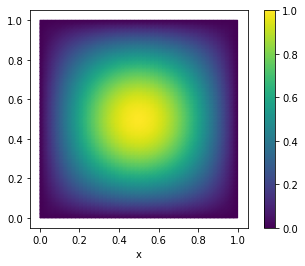

In [12]:
#sanity check integrating over 2 dimensions
mesh1=RectangleMesh(Point(0,0),Point(1,1),50,50)
E1=Expression('sin(pi*x[0])*sin(pi*x[1])',degree=4,domain=mesh1)
V=FunctionSpace(mesh1,'P',2)
E1_func=project(E1,V)
int1=assemble(E1_func*dx(mesh1))
print(int1)
c = plot(E1_func, mode='color')
plt.colorbar(c)
plt.xlabel('x')
plt.show()


1.5


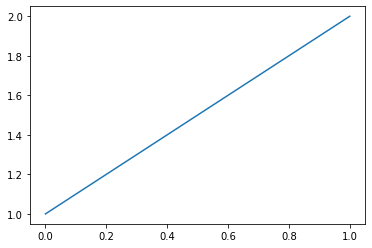

In [13]:


#here is example from online how to integrate a 2d function in a 1d subdomain
#2D domain to define u(x,y)
m_2D=RectangleMesh(Point(0.,0.),Point(1.,1.),10,10)

V_2D=FunctionSpace(m_2D, "CG",1)

U_2D_e=Expression('x[0]+x[1]',degree=1)

U_2D_f=interpolate(U_2D_e,V_2D)

#plot(U_2D_f)
#1D integration domain
m_1D=IntervalMesh(20,0.,1.)
V_1D=FunctionSpace(m_1D, "CG",1)

#an Expression class to evaluate u(x,y) on the 1D domain (range y, x fixed)

class my1DExpression(UserExpression):
    def __init__(self,u_2d,x,**kwargs):
        super().__init__(**kwargs)
        self.u_2d=u_2d
        self.x=x
        #Expression.__init__(self)
        self._vx= np.array([0.])
        self._pt_x= np.array([0.,0.])
    def eval(self, values, x):
        self._pt_x[0]= self.x
        self._pt_x[1]= x[0]
        self.u_2d.eval(self._vx,self._pt_x)
        values[0] = self._vx[0]



#An exemple int_0^1 x+y dy=x+1/2
#for x in np.linspace(0.,1.,10):
x=1.0
test1=my1DExpression(U_2D_f,x=x)
Uy=interpolate(test1,V_1D)
intUy=assemble(Uy*dx)
print(intUy)

#it is possible to define the u(x) function
#class UxExpression(Expression):
#    def __init__(self,u_2d):
#        self.u_2d=u_2d
#        self.x=x
#        Expression.__init__(self)
#    def eval(self, values, x):
#        _Uy=interpolate(my1DExpression(U_2D_f,x=x[0]),V_1D)
#        values[0] = assemble(_Uy*dx)

#1D for ux
#m_1Dx=IntervalMesh(20,0.,1.)
#V_1Dx=FunctionSpace(m_1Dx, "CG",1)

#Ux_f=interpolate(UxExpression(U_2D_f),V_1Dx)
plot(Uy)

0.499334822684


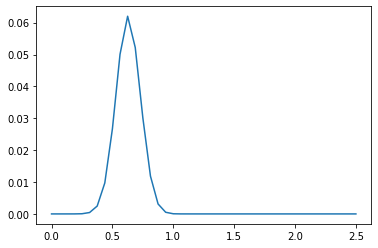

In [14]:
#test example for 1d spectrum that varies along space
omega_min=0 #smallest rad. frequency (needs to be larger than 0)
omega_max = 2.5 #largest rad. frequency
n_sigma = 40 #number of elements in frequncy which is dimension no. 0   
y_start = 0 #startig point in space
y_end = 4000 #endpoint
n_space = 45 #number of elements in direction which is dimension no. 1

mesh1=RectangleMesh(Point(y_start,omega_min),Point(y_end,omega_max),n_sigma,n_space)

#specify parameters for the gauss expression
F_peak=0.1
F_std=0.1
theta_peak=0
HS=1
#define expression
aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
aux3 = 2*F_std**2

#let it vary in y
E=Expression('pow(x[0]/y_end,2)*aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3)',
             degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak,y_end=y_end)
#define function space to project to (optional)
V=FunctionSpace(mesh1, 'P', 1)
E_func=project(E,V)


#now see if we can integrate in 1 d at a given point
#1D integration domain, (this is hard coded for doing 1d domain in y direction)
m_1D=IntervalMesh(n_sigma,omega_min,omega_max)
V_1D=FunctionSpace(m_1D, "CG",1)

x=2000
test1=my1DExpression(E_func,x=x)
Uy=interpolate(test1,V_1D)
intUy=assemble(Uy*dx)
print(4*np.sqrt(intUy))
plot(Uy)



computed HS (should be 1)
1.0000365205


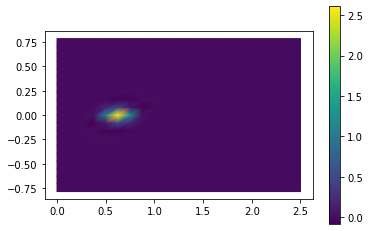

In [15]:
#now test if 1d and 2d integrations agree

#2D
def Gauss_Expression(F_peak,F_std,theta_peak,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('aux1*exp(-pow(x[0]-2*pi*F_peak,2)/aux3)*CTOT*pow(cos(x[1]-theta_peak),500)',
                degree=4,aux1=aux1,aux3=aux3,CTOT=CTOT,theta_peak=theta_peak,F_peak=F_peak)
    return E


#see if we can create 1d version that integrates to be the same
omega_min=0 #smallest rad. frequency (needs to be larger than 0)
omega_max = 2.5 #largest rad. frequency
theta_min=-np.pi/4 #lowest direction (in radians)
theta_max=np.pi/4 #highest direction (in radians)
n_sigma = 20 #number of elements in frequncy which is dimension no. 0   
n_theta = 20 #number of elements in direction which is dimension no. 1

mesh1=RectangleMesh(Point(omega_min,theta_min),Point(omega_max,theta_max),n_sigma,n_theta)

#specify parameters for the gauss expression
F_peak=0.1
F_std=0.1
theta_peak=0
HS=1
#define expression
E=Gauss_Expression(F_peak,F_std,theta_peak,HS)
#define function space to project to (optional)
V=FunctionSpace(mesh1, 'P', 1)
E_func=project(E,V)
#integrate
Hs_computed=assemble(E_func*dx(mesh1))
print('computed HS (should be 1)')
print(4*np.sqrt(Hs_computed))

c = plot(E_func, mode='color')
plt.colorbar(c)

plt.show()

computed HS (should be 1)
0.999999999917


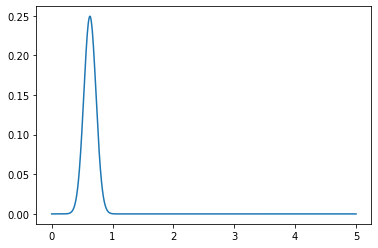

In [17]:
#now 1d verson (omitting theta)
def Gauss_Expression_1D(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('aux1*exp(-pow(x[0]-2*pi*F_peak,2)/aux3)',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak)
    return E
omega_min=0 #smallest rad. frequency (needs to be larger than 0)
omega_max = 5 #largest rad. frequency
n_sigma = 1000 #number of elements in frequncy which is dimension no. 0 
mesh1=IntervalMesh(n_sigma,omega_min,omega_max)
F_peak=0.1
F_std=0.1
HS=1
E=Gauss_Expression_1D(F_peak,F_std,HS)
V=FunctionSpace(mesh1, 'P', 1)
E_func=project(E,V)

Hs_computed=assemble(E_func*dx(mesh1))

print('computed HS (should be 1)')
print(4*np.sqrt(Hs_computed))
plot(E_func)